# LTI - Singular Spectrum Analysis

## Formulation derived from Linear time-invariant theory (LTI system theory). 

REF: SSA of biomedical signals: A linear invariant systems approach. A.M. Tomé, A.R. Teixeira, N. Figueiredo, I.M. Santos, P. Georgieva and E.W. Lang.


Aditional REF: https://www.sciencedirect.com/science/article/abs/pii/S105120041830530X

In [1]:
import numpy as np
import soundfile as sf
from scipy.linalg import svd, toeplitz
from scipy.stats import zscore
from statsmodels.tsa.stattools import acf
# from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline

### Loading signal

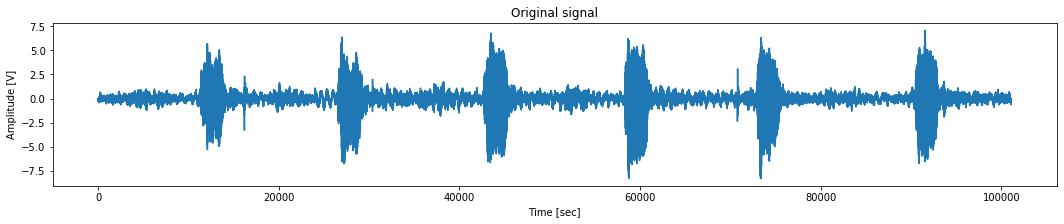

In [2]:
# load bioacoustic signal (an anuran call recorded into the rainforest)
x, fs = sf.read('hylaedactylus_1_44khz.flac') 
x = zscore(x) # signal nomalization

plt.figure(figsize=(18,3))
plt.plot(x)
plt.ylabel('Amplitude [V]')
plt.xlabel('Time [sec]')
plt.title('Original signal')
plt.show()

### Step 1: autocorrelation matrix

In [3]:
lag = 20
ACF = acf(x, nlags=lag-1, unbiased=True, fft=True)
Sxx = toeplitz(ACF)

### Step 2: SVD of the autocorrelation matrix

In [4]:
U, d, _ = svd(Sxx)

#### Singular spectrum visualization

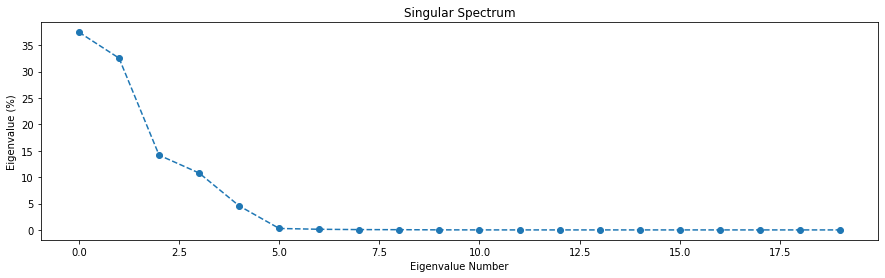

In [5]:
plt.figure(figsize=(15,4))
plt.plot((d/np.sum(d))*100,'--o') # d => eigenvalues, Normalized singular spectrum
plt.title('Singular Spectrum')
plt.xlabel('Eigenvalue Number')
plt.ylabel('Eigenvalue (%)')
plt.show()

### Step 3: generate each component by filtering

In [6]:
components = np.zeros((lag,len(x)))
for l in range(lag):
    u = U[:,l]                            # each column of U becomes a FIR filter of t
    t = np.convolve(u, np.flip(u))/ (lag) # FIRs 
    y = np.convolve(x, t)                 # filtered components, these are similar to the SVD singular components
    components[l,:] = y[lag-1:-lag+1]

### Step 4: grouping relevant components and reconstruction

RMS Error:  44.581860969362744


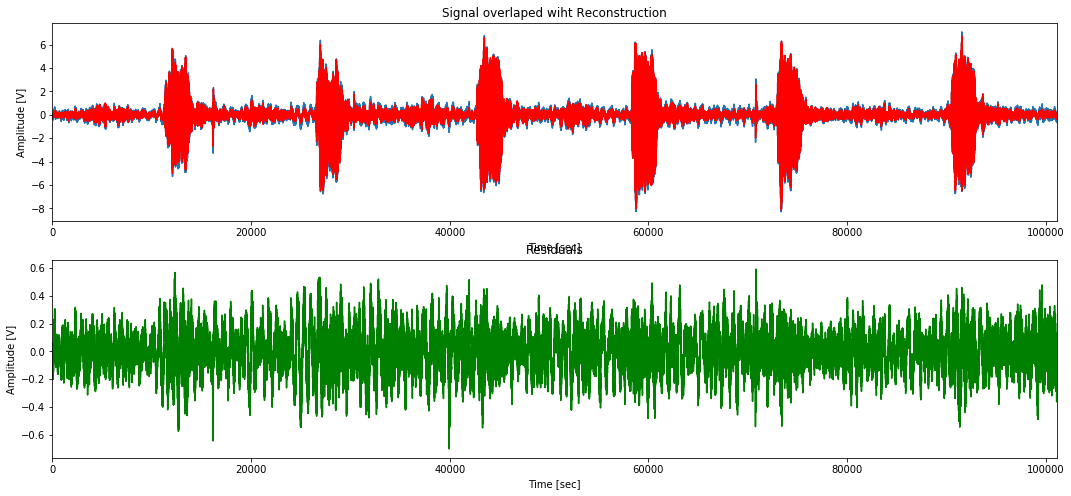

In [7]:
c = [0,1,2,3]  # Selection of components to generate the reconstruction.
y = np.sum(components[c,:], axis=0)

print('RMS Error: ',np.sqrt(np.sum(np.power(x-y,2))))

plt.figure(figsize=(18,8))
plt.subplot(2,1,1)
plt.plot(x, label='Original')
plt.plot(y,'red', label='Reconstruction')
plt.xlim([0,len(x)])
plt.ylabel('Amplitude [V]')
plt.xlabel('Time [sec]')
plt.title('Signal overlaped wiht Reconstruction')
plt.subplot(2,1,2)
plt.plot(x-y,'green')
plt.xlim([0,len(x)])
plt.ylabel('Amplitude [V]')
plt.xlabel('Time [sec]')
plt.title('Residuals')
plt.show()

### Example of reconstruction with a single component.

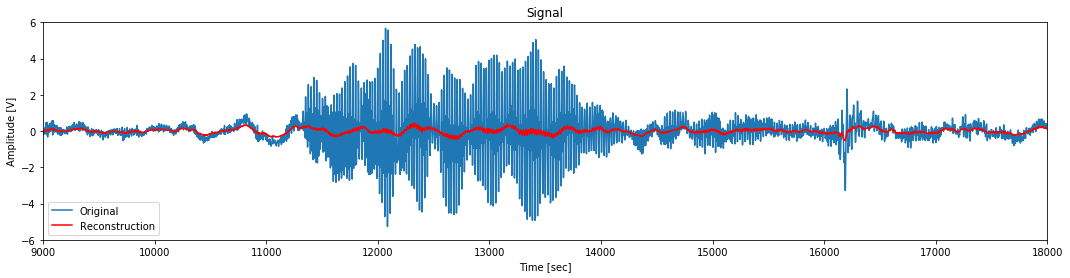

In [8]:
# reconstrução usando primeira componente
c = [4]
y = np.sum(components[c,:], axis=0)

plt.figure(figsize=(18,4))
plt.plot(x, label='Original')
plt.plot(y,'red', label='Reconstruction')
plt.xlim([9000,18000])
plt.ylim([-6,6])
plt.ylabel('Amplitude [V]')
plt.xlabel('Time [sec]')
plt.title('Signal')
plt.legend(loc='lower left')
plt.show()

### Plotting the frequency response of the first three filters

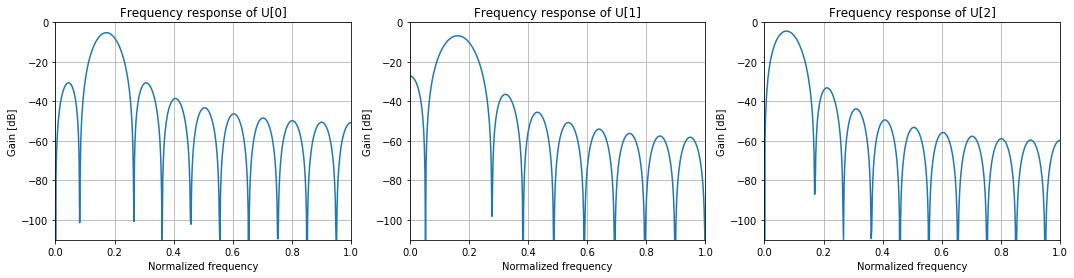

In [11]:
plt.figure(figsize=(18,4))
for i in range(3):
    FIR = np.convolve(U[:,i], np.flip(U[:,i]))/ (lag)

    # Pad filter with zeros.
    h_padded = np.zeros(1024)
    h_padded[0 : len(FIR)] = FIR

    # Compute frequency response; only keep first half.
    H = np.abs(np.fft.fft(h_padded))[0 : 1024 // 2 + 1]

    # Plot frequency response (in dB).
    plt.subplot(1,3,i+1)
    plt.plot(np.linspace(0, 1, len(H)), 20 * np.log10(H))
    plt.xlabel('Normalized frequency')
    plt.ylabel('Gain [dB]')
    plt.title('Frequency response of U['+ str(i) + ']')
    plt.xlim([0, 1])
    plt.ylim([-110, 0])
    plt.grid()
plt.show()